# **Distracted Driver Detection**
### **Image Classification with Deep Learning**
### **Model 2 — Custom CNN with Data Augmentation (Batch 64 · Adam · α = 0.005)**

--------------------------

# **Project Overview**

Distracted driving is one of the leading causes of road accidents worldwide. This project explores whether a Computer Vision model can accurately detect and classify different driver behaviors from in-car images, enabling real-time distraction detection systems.

Given a dataset of driver images captured inside vehicles, the goal is to classify each image into one of **10 distraction categories**:

- **c0:** Safe driving
- **c1:** Texting — right
- **c2:** Talking on the phone — right
- **c3:** Texting — left
- **c4:** Talking on the phone — left
- **c5:** Operating the radio
- **c6:** Drinking
- **c7:** Reaching behind
- **c8:** Hair and makeup
- **c9:** Talking to passenger

This notebook builds on the baseline CNN by introducing **data augmentation** (rotation, shifts, vignette effects) and a **higher learning rate** to improve generalization and reduce background noise influence.

--------------------------

# **Implementation**

### **• Libraries and Module Imports:**

Importing the necessary libraries and modules to manipulate and interact with the dataset.

In [25]:
# Importing the necessary libraries and modules.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf
import os
from random import randint
import random
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.models import load_model
from keras.models import save_model
from keras import backend as K
from keras import Model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
import seaborn as sns

### **• Loading the Data:**

Loading the Drivers list CSV and setting the paths for the Training and Testing images.

In [26]:
# Loading the Driver Images list CSV.
drivers_images_list_df = pd.read_csv('Data/driver_imgs_list.csv')

In [27]:
# Checking the information and schema of the dataframe.
drivers_images_list_df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [28]:
# Defining the Training images folder path in order to feed the different models.
training_folder_path = 'Data/imgs/train'

In [29]:
# Defining the Training images folder path in order to feed the different models.
testing_folder_path = 'Data/imgs/test'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **PART I: Data Exploration**

### **• Central Question:**

#### *"Can a Computer Vision Model be built in order to be able to detect and properly classify different drivers behaviors while driving?"*

### **• Raw Data Amount:**

Given the amount of data that is necessary in order to feed an effective and accurate Computer Vision model, it is mandatory to check how many data points are available both for training and testing. 

In [30]:
# Defining a function to count the number of images that are available in the provided directories.
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

In [31]:
# Identifying the number of images in the training set.
train_file_count = count_files(training_folder_path)
print(f" The Training set contains {train_file_count} images.")

 The Training set contains 22424 images.


In [32]:
# Identifying the number of images in the testing set.
test_file_count = count_files(testing_folder_path)
print(f" The Testing set contains {test_file_count} images.")

 The Testing set contains 79726 images.


**Resulting Hypothesis:** Given the considerable size of both the training and testing image sets and the fairly easy identifiable visual patterns in the actions that the drivers are performing, data augmentation for the purpose of increasing the data that is fed to the model may not be necessary. 

Despite this, for other purposes, like improving generalization - to expose the model to different picture variations (i.e., scalings, different lighting conditions ...), this process might still be advisable in some batches in order to make the models more robust and performing in different real-world scenarions.

### **• Raw Data Dimentions:**

Given the importance of standardizing image dimensions in some Computer Vision models, for these to be able to identify the right patterns and relationships between pixels, it is crucial to check if all training images follow the same dimensions.

In [33]:
# Constructing a function to check if the images dimensions is constant and what dimensions do they present.
def check_image_dimensions(root_dir):
    dimensions = None
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            for file_name in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file_name)
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image = Image.open(file_path)
                    img_width, img_height = image.size
                    if dimensions is None:
                        dimensions = (img_width, img_height)
                    elif dimensions != (img_width, img_height):
                        print(f"Inconsistent dimensions found in {file_path}. Expected: {dimensions}, Actual: ({img_width}, {img_height})")
    if dimensions is not None:
         print("All images have consistent dimensions:", dimensions)

In [34]:
# Checking the image dimensions on the Training set.
check_image_dimensions(training_folder_path)

All images have consistent dimensions: (640, 480)


### **• Raw Data Visualization:**

In order to better know which activities the later built models will need to identify, it is helpful to visualize at least a picture of each class to know what patterns to expect.

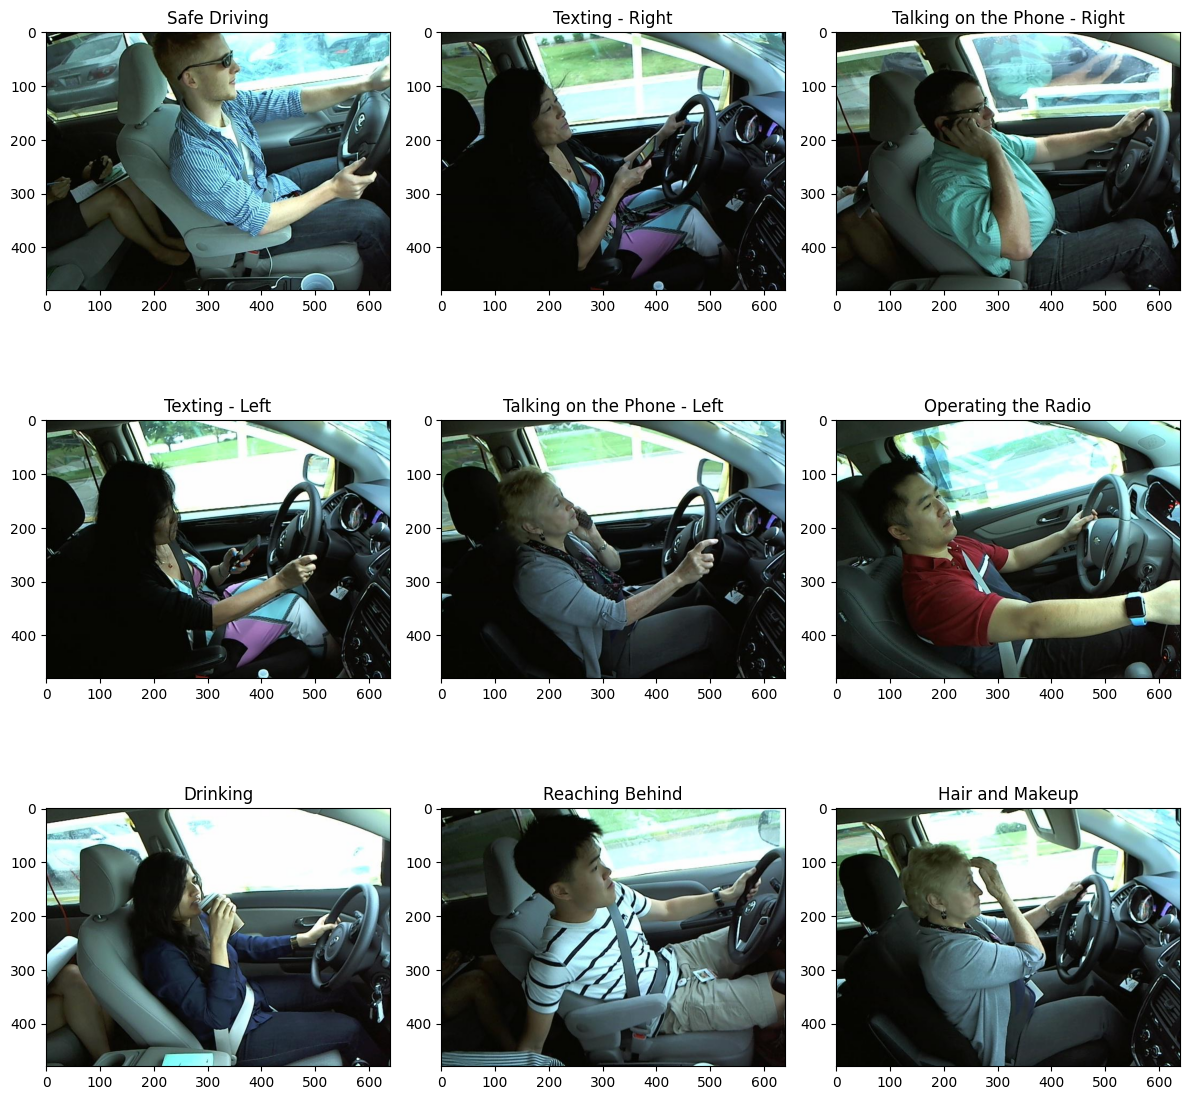

In [35]:
# Identifying the image directory where the images are stored.
image_dir = training_folder_path

# Mapping of activity titles for each type.
activity_classes = {
    "c0": "Safe Driving",
    "c1": "Texting - Right",
    "c2": "Talking on the Phone - Right",
    "c3": "Texting - Left",
    "c4": "Talking on the Phone - Left",
    "c5": "Operating the Radio",
    "c6": "Drinking",
    "c7": "Reaching Behind",
    "c8": "Hair and Makeup",
    "c9": "Talking to Passenger"
}

# Initializing a subplot to display the images.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.ravel()

# Looping through each activity type and displaying one image with the corresponding title.
for i, activity_type in enumerate(sorted(activity_classes.keys())[:9]):
    
    # Getting the path of the first image for the activity type.
    activity_dir = os.path.join(image_dir, activity_type)
    image_name = os.listdir(activity_dir)[0]
    image_path = os.path.join(activity_dir, image_name)
    
    # Loading and displaying the images.
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(activity_classes[activity_type])
    axes[i].axis('on')

# Adjusting image spacing and displaying the plots.
plt.tight_layout()
plt.show()

### **• Class and Subject Data Distribution:**

It is important to confirm that the number of images per distractor activity class and driver is balanced so that the models don't become biased towards a majority class or individual image set. This way, there will be enough generaliation and robustness and data scarcity will be avoided.

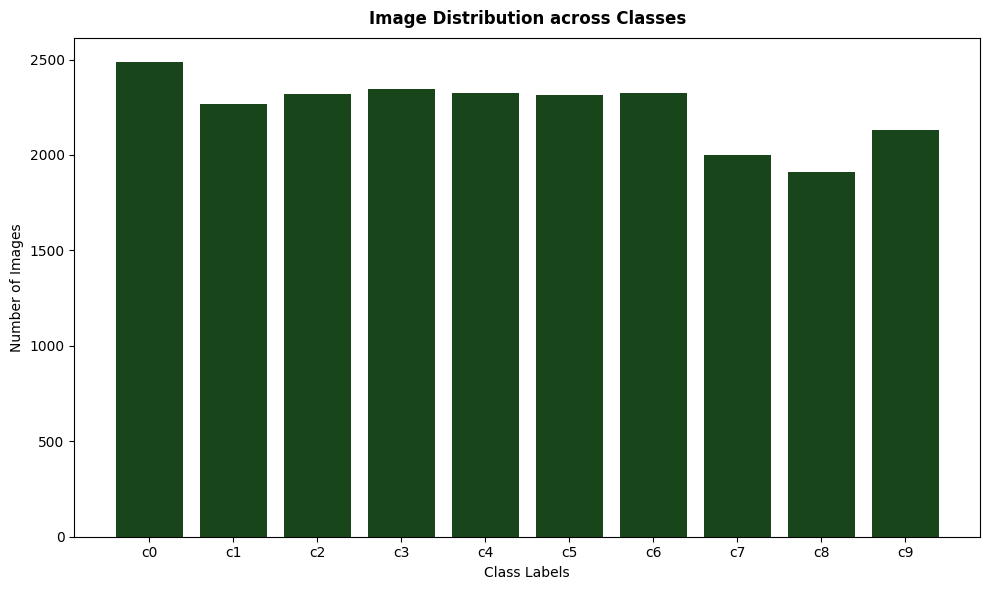

In [36]:
# Initializing empty lists to store class labels and corresponding image counts.
class_labels = []
image_counts = []

# Iterating through each subdirectory in the train directory and appending the different counts.
for subdir in os.listdir(image_dir):
    subdir_path = os.path.join(image_dir, subdir)
    if os.path.isdir(subdir_path):
        class_labels.append(subdir)
        image_counts.append(len(os.listdir(subdir_path)))

# Plotting a vertical bar chart with the class data distribution.
plt.figure(figsize=(10, 6))
plt.bar(class_labels, image_counts, color = '#18461a')
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Image Distribution across Classes", fontweight='bold', pad=10)
plt.tight_layout()
plt.show()

**Insight:** Since the training dataset is fairly balanced, there appears to be no need for downsampling data. 

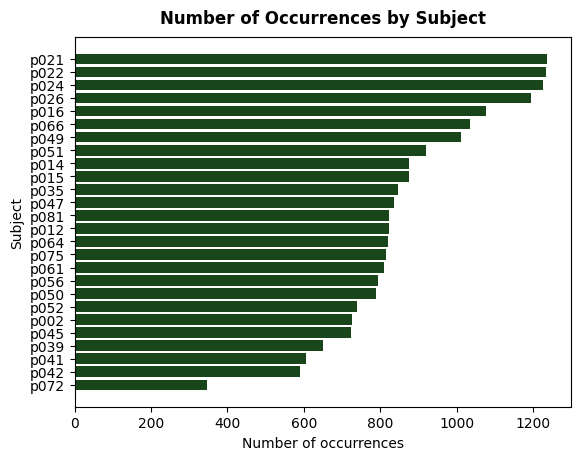

In [37]:
# Countng the number of occurrences of each subject.
subject_counts = drivers_images_list_df['subject'].value_counts()

# Sorting the subjects based on their counts in descending order.
subject_counts = subject_counts.sort_values(ascending=True)

# Creating a horizontal bar chart.
plt.barh(subject_counts.index, subject_counts.values, color = '#18461a')

# Setting the chart title.
plt.title('Number of Occurrences by Subject',fontweight='bold', pad=10)

# Setting labels for the x and y axes.
plt.xlabel('Number of occurrences')
plt.ylabel('Subject')

# Displaying the chart.
plt.show()

**Insight:** As observable, some individuals have less images to be trained on. Due to this fact, it is expected that the model will learn more from the behaviour of the subjects with more available data, leading to a higher number of right predictions on their images.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## **Model 2 - Custom CNN (Batch 64 - Adam - α = 0.005):**

For the second version of the CNN model, the previously discussed improvement opportunities will be implemented.

### **PART II: Data Preprocessing**

### **• Image Normalization:**

This step is commonly performed on images before feeding them into a deep learning model. By dividing each pixel value in an image by a scaling factor (in this case 255) pixel values will be brought to a standardized range between 0 and 1. In terms of the benefits of this step, 2 can be highlighted:

- **Gradient Convergence:** In order to properly update models' weights, algorithms usually work better when the input features (pixels) are within the same numerical range, hence normalization helps to increase the efficiency and stability of convergence. 

- **Model Generalization:** Normalizing pixel values usually improves models' generalization performance, as these become less sensitive to input intensity levels (i.e., dealing better with illumination, contrasts... across images).

### **• Data Augmentation:**

Data Augmentation is a crucial step in the preprocessing of image data, particularly beneficial for deep learning models. It helps to enlarge the dataset with transformed images, thus enabling the model to learn more robust features and reducing the risk of overfitting. Despite the solid number of images that were reserved for the training stage, this step will try to reduce the noise that was coming from the exterior of the car window as well as make the model more robust to different image settings.

The transformations that will be performed are the following:

- **Rotation, Width and Height Shifts:** These transformations slightly rotate the image and shift it horizontally and vertically. They allow the model to learn invariance to these perturbations.

- **Shear Transformation:** This distorts the image along an axis, which can simulate different viewing conditions.

- **Zoom:** This simulates the effect of the object being closer or further away.

- **Fill Mode:** This decides how newly created pixels will be filled after rotation or width/height shifts. The "nearest" method fills these pixels with the closest ones.

- **Brightness Range:** This randomly adjusts the brightness of the image, aiding the model in dealing with different lighting conditions.

- **Vignette Effect:** A vignette is applied to darken the periphery of the image, helping to reduce the noise from outside the car window. This encourages the model to focus on central features and reduce the impact of potentially distracting elements at the image edges.

In [38]:
# Setting the data augmentation transformations.

rotation_range = 4
width_shift_range = 0.01
height_shift_range = 0.01
shear_range = 0.02
zoom_range = 0.05
fill_mode = "nearest"
brightness_range = (0.9, 1.4)

In [39]:
# Defining the vignette preprocessing function.

def add_vignette(image):
    # Defining parameters for vignette effect.
    rows, cols = image.shape[:2]
    kernel_x = cv2.getGaussianKernel(cols,200)
    kernel_y = cv2.getGaussianKernel(rows,200)
    kernel = kernel_y * kernel_x.T
    mask = 255 * kernel / np.linalg.norm(kernel)
    output = np.copy(image)
    
    # Applying a vignette mask to each channel in the image.
    for i in range(3):
        output[:,:,i] = output[:,:,i] * mask

    return output

In [40]:
# Normalizing pixel values by dviding feature values by 255.
# Holding back 30% of the images for validation.
print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.3,
                             preprocessing_function=add_vignette,
                             rotation_range=rotation_range,
                             width_shift_range=width_shift_range,
                             height_shift_range=height_shift_range,
                             shear_range=shear_range,
                             zoom_range=zoom_range,
                             fill_mode=fill_mode,
                             brightness_range=brightness_range)

Getting Data...


### **• Hyperparameter Setting 2:**

In deep learning models, instead of updating models' parameters after each individual sample training is usually performed in **batches**. This batch size should be defined in order to determine how many samples will be processed together in parallel before updating the models' weights. Larger batch sizes can lead to smoother updates to the weights since they average gradients across samples, whereas smaller batches can lead to faster convergence at the cost of some noisy updates that may add some not so good oscillations in the training process.

Additionally, it is also important to **set the right image dimensions** for the training data. Although larger sized images tend to preserve more spatial information, some of this detail may not be necessary for all types of tasks and could significantly increase the amount of computational power needed to train (leading to slower convergence).

In [41]:
# Defining a batch size.
batch_size = 64

# Defining the image dimensions.
img_size = (128,128)

### **• Set Training and Validation Data:**

The validation split is a common practice in deep learning to assess the model's performance on unseen data and prevent overfitting. By holding back a portion of the images for validation, the model can be evaluated on data it hasn't seen during training, providing a more reliable estimate of its performance on new, unseen samples. During training, the model's performance is monitored using the training set, while the validation set helps in identifying potential issues like overfitting or underfitting. It allows for adjusting model hyperparameters, such as learning rate or regularization, based on the validation performance to optimize the model's performance on unseen data.

In this case, 30% of the images will be set aside for validation, while the remaining 70% will be used for training the model.

In [42]:
# Setting the Training data.
print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    training_folder_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

# Setting the Validation data.
print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    training_folder_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Preparing training dataset...
Found 15702 images belonging to 10 classes.
Preparing validation dataset...
Found 6722 images belonging to 10 classes.


### **PART III: Model Definition**

### **• Model Elements:**

In order to define a Convolutional Neural Network (CNN) model, there are a certain elements that need to be involved:

1. **Model Type**: Sequential is a straightforward model type that allows to define a linear stack of sequential layers that build a CNN.

2. **Optimizer:** Element responsible for updating the model's parameters during training in order to minimize loss. These ones determine how models' adjust their weights based on computed gradients. Each optimizer has its own algorithm and hyperparameters.

3. **Learning Rate:** This one is the hyperparameter that controls the step size taken during each model's update of its parameters. It determines the speed at which the model learns and how quickly it converges. It is always important to define a proper learning rate value. If the learning rate is too high, the model might fail to converge into the optimal solution, if its too slow, the model might take an unecessary amount of time to find an optimal or suboptimal solution.

4. **Convolutional Layers:** These are the core blocks of CNNs. By applying kernels or filters to the input data, the network will learn spacial hierarchies of features and local patterns between pixels allowing it to be able to better classify images. These layers usually perform actions like edge, texture or shape recognition.

5. **(Optional) Padding:** This technique consists of adding extra pixels or values around the borders of an image or feature map. Padding can be useful for both maintaining the spatial information at the borders of the input and also to retain the original size of the input or feature map, allowing the subsequent layers to process information from the entire input space. There are two types of padding: "valid" and "same." In the "valid" padding scheme, no padding is added, and the output size is reduced due to the filter/kernel sliding across the input. In contrast, the "same" padding scheme adds padding equally to all sides of the input, ensuring that the output size matches the input size.

6. **(Optional) Max Pooling:** Downsampling technique that is able to reduce the spatial dimensions of the input by selecting the maximum value value within a local region of the input feature map. This step, although optional, helps reduce computational complexity by extracting only the most important features, enhancing models' translation invariance (ability of a model to recognize and understand objects or patterns regardless of their position or location within an image).

7. **(Optional) Dropout:** Regularization technique that is used to prevent overfitting and improve models' generalization performance. By randomly droping out a fraction of the input units (neurons) to zero at each update, this element forces netwroks to learn more robust and generalizable features by reducing the reliance on specific neurons and promoting distribute learning across a wider range of units.

8. **Flatten:** Since the last layers of the network expect a one-dimensional input, the flatten step is necessary in order to reshape a matrix or tensor into a vector format.

9. **Dense Layers:** Also known as fully connected layers, are layers where each neuron is connected to every other neuron in the previous and next layers. These layers can help to capture global relationships, and make the final prediction based on the learned features.

10. **Loss Function:** For multi-class classification tasks, categorical cross entropy is a popular loss function that measures the dissimilarity between the predicted class probabilities and the true class labels. The end goal of every model its to minimize this loss function during training, in order to generate more accurate class predictions.

### **• Model 2 - Custom CNN (Batch 64 - Adam - α = 0.005) Configuration:**

For a second attempt at building a performing model for these distracted driver actions image classification, the same custom sequence of layers as layer 1 will be made to the input data since it performed extremely well:

1. **Convolutional Layer** (Filters - 32; Kernel Size - 2, Padding - Same, Activation - ReLU)

2. **Max Pooling Layer**(Pool Size - 2)

3. **Convolutional Layer** (Filters - 64; Kernel Size - 2, Padding - Same, Activation - ReLU)

4. **Max Pooling Layer** (Pool Size - 2)

5. **Convolutional Layer** (Filters - 64; Kernel Size - 2, Padding - Same, Activation - ReLU)

6. **Max Pooling Layer** (Pool Size - 2)

7. **Dropout Layer** (Dropout Rate: 0.5)

8. **Flatten Layer**

9. **Dense Layer** (Number of Units - # Classes, Activation - Softmax)

In terms of the **optimizer**, the one chosen will be **Adam** - a popular method in deep learning that computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

In terms of the **loss function**, the one chosen will be **Categorical Cross Entropy**.

In terms of the **learning rate**, this one will be increased 5X, reaching an α of 0.005. As model 1 performed really well from early on, for a slight increase in the learning rate it might be expected that the accuracy metrics will hold while the computational speed will improve.

In [43]:
# Defining the model as a sequence of layers.
model_2 = Sequential()

# Applying a convulotional layer that uses 32 2x2 filters, same padding scheme, and a rectified liner unit activation function.
model_2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=train_generator.image_shape))

# Adding a max pooling layer with a 2x2 patch.
model_2.add(MaxPooling2D(pool_size=(2,2)))

# Applying a convulotional layer that uses 64 2x2 filters, same padding scheme, and a rectified liner unit activation function.
model_2.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))

# Adding a max pooling layer with a 2x2 patch.
model_2.add(MaxPooling2D(pool_size=(2,2)))

# Applying a convulotional layer that uses 64 2x2 filters, same padding scheme, and a rectified liner unit activation function.
model_2.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))

# Applying a dropout of 50% of the neurons.
model_2.add(Dropout(0.5))

# Flattening the multidimensional input data.
model_2.add(Flatten())

# Applying a dense layer to geenrate the predicted probabilities for each class.
model_2.add(Dense(train_generator.num_classes, activation='softmax'))

In [44]:
# Defining the optimizer.
opt_2 = tf.optimizers.Adam(learning_rate=0.005)

In [45]:
# Compiling the model for categorical multi-class classification.
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt_2,
              metrics=['accuracy'])

In [46]:
# Checking the model 2 summary.
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        8256      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       32896     
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)      

### **PART IV: Training Stage**

### **• Train Model 2 - Custom CNN (Batch 64 - Adam - α = 0.005):**

With the CNN layers defined, the model is now prepared for training using the training image data. The training process will consist of 6 iterations, or epochs, as model 1 quickly converged before reaching 8 iterations. The training will be performed in batches of 64 images, slightly less than in the previous model. Additionally, 30% of the data will be reserved for validation purposes. After each epoch, the loss function will evaluate the model's error (loss) and adjust its randomly initialized weights in an effort to enhance accuracy.

In [47]:
# Setting the number of epochs.
num_epochs = 6

# Training the model.
history = model_2.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/6
245/245 [==============================] - 184s 748ms/step - loss: 0.9680 - accuracy: 0.6904 - val_loss: 0.2513 - val_accuracy: 0.9290
Epoch 2/6
245/245 [==============================] - 182s 743ms/step - loss: 0.2051 - accuracy: 0.9384 - val_loss: 0.1299 - val_accuracy: 0.9624
Epoch 3/6
245/245 [==============================] - 193s 787ms/step - loss: 0.1272 - accuracy: 0.9619 - val_loss: 0.0886 - val_accuracy: 0.9735
Epoch 4/6
245/245 [==============================] - 203s 827ms/step - loss: 0.0890 - accuracy: 0.9742 - val_loss: 0.0662 - val_accuracy: 0.9793
Epoch 5/6
245/245 [==============================] - 203s 830ms/step - loss: 0.0752 - accuracy: 0.9767 - val_loss: 0.0642 - val_accuracy: 0.9833
Epoch 6/6
245/245 [==============================] - 205s 838ms/step - loss: 0.0662 - accuracy: 0.9784 - val_loss: 0.0734 - val_accuracy: 0.9777


### **• Visualize Loss History for Model 2 - Custom CNN (Batch 64 - Adam - α = 0.005):**

Once trained, it is necessary to verify the reduction history of the loss function as well as if the model is over-fitted - learning to perform extremely well on the training data, but failing to generalize and perform well on unseen data. This overfitting can be spotted by a continuos drop in training loss after validation loss has levelled out or started to increase. 

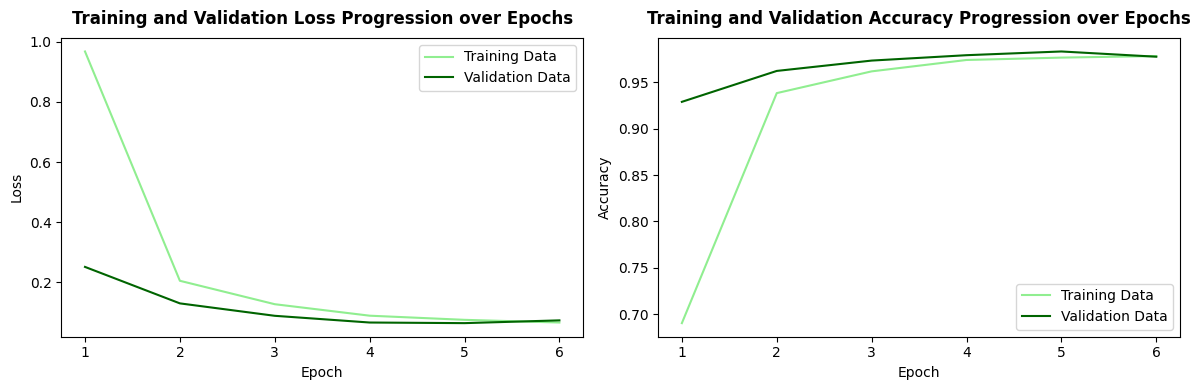

In [48]:
# Plotting the training and validation loss progression over epochs.
%matplotlib inline

# Plotting the training and validation loss progression over epochs.
plt.figure(figsize=(12, 4))

# Plotting the loss
plt.subplot(1, 2, 1)
epoch_nums = range(1, num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss, color='lightgreen')
plt.plot(epoch_nums, validation_loss, color='darkgreen')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and Validation Loss Progression over Epochs", fontweight='bold', pad=10)
plt.legend(['Training Data', 'Validation Data'], loc='upper right')

# Plotting the accuracy
plt.subplot(1, 2, 2)
training_acc = history.history["accuracy"]
validation_acc = history.history["val_accuracy"]
plt.plot(epoch_nums, training_acc, color='lightgreen')
plt.plot(epoch_nums, validation_acc, color='darkgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Validation Accuracy Progression over Epochs", fontweight='bold', pad=10)
plt.legend(['Training Data', 'Validation Data'], loc='lower right')

plt.tight_layout()
plt.show()

**Insights:** As observed, the loss on the training set still decreases rapidly for the first two epochs (indicating that not a lot more epochs are needed for the network to be trained further). For the validation set, although the loss still does not decrease at the exact same rate as the training set, this one keeps improving until epoch 5. Beyond epoch 5, the training data accuracy continues to rise whereas the validation data accuracy gets worse, hence some overfitting or in other words, memorization of data starts to take place.

### **• Visualize Grad-CAM for Model 2 - Custom CNN (Batch 64 - Adam - α = 0.005):**

In order to visualize the patterns that our model saw in the images before making a prediction, a Grad-CAM technique was applied.

1/1 [==============================] - 0s 18ms/step


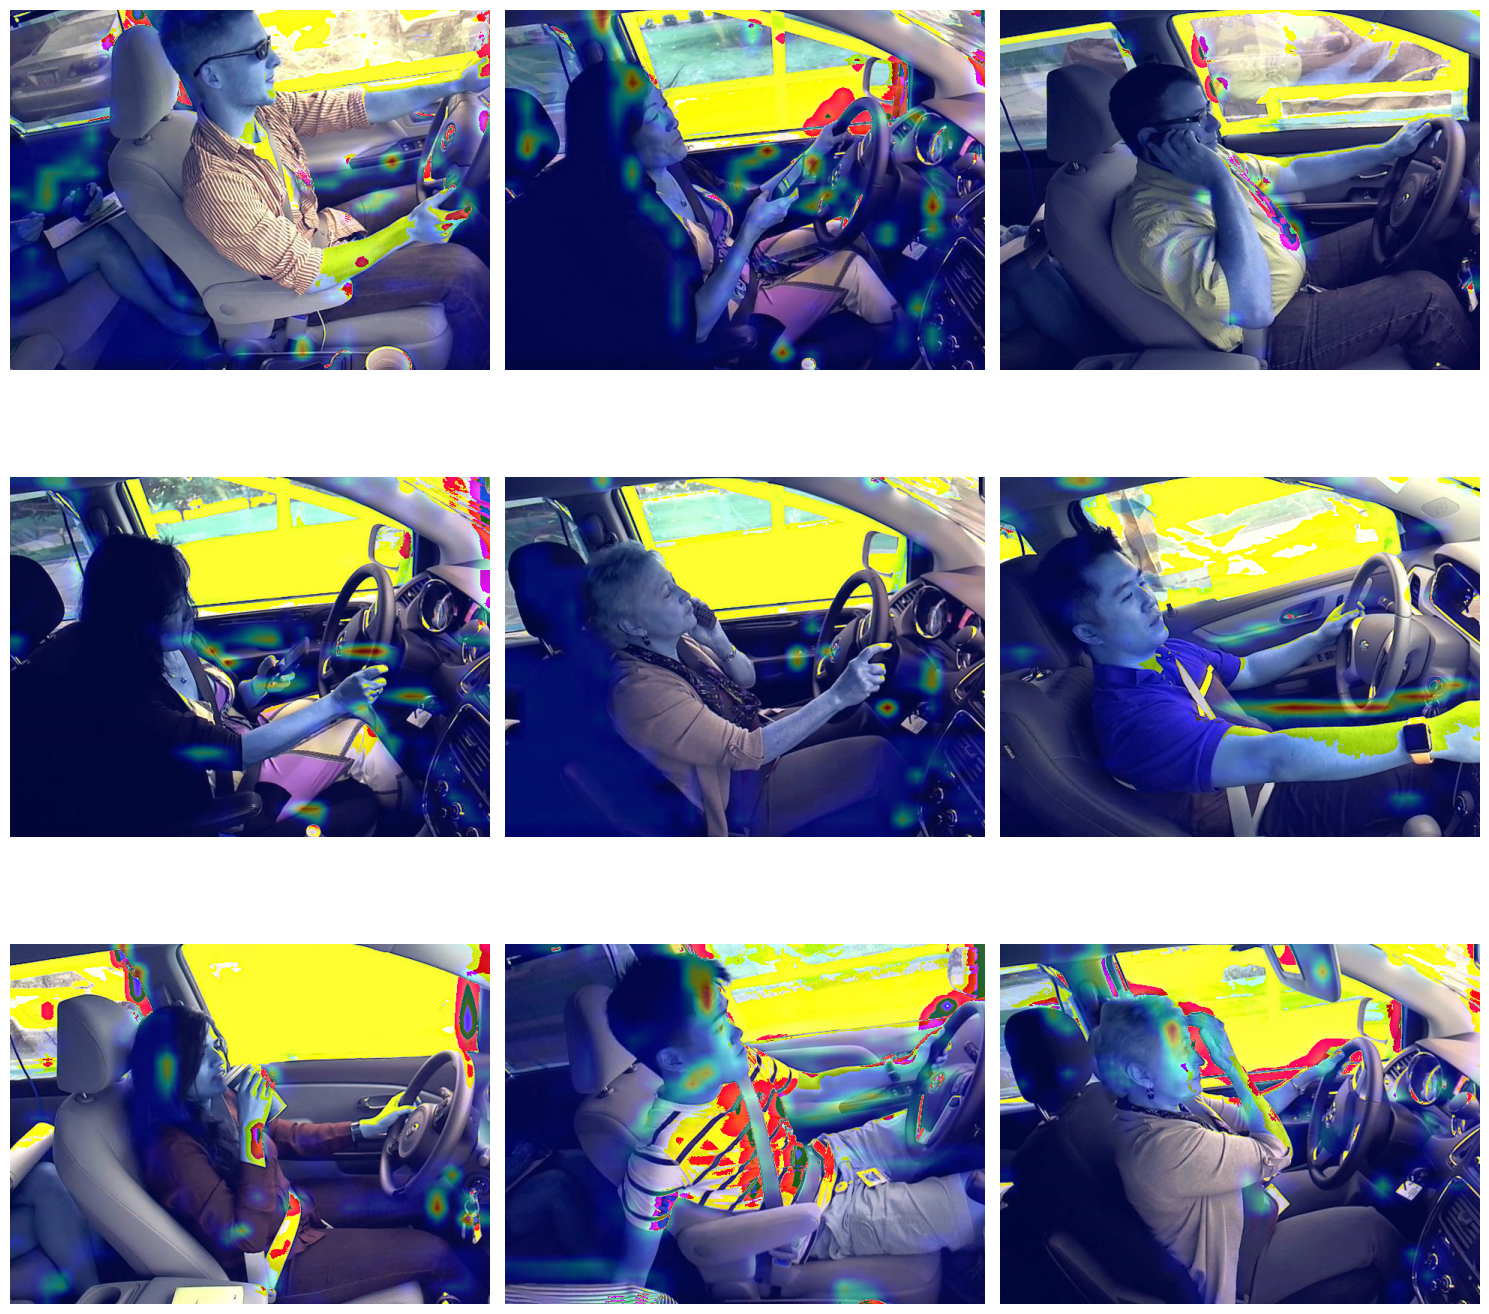

In [50]:
# Creating a list for the images.
img_paths = []

# Assigning the parent directory of the images.
parent_dir = training_folder_path

# Looping through each subdirectory in the parent directory.
for sub_dir in os.listdir(parent_dir):
    
    # Getting the path of the first image in the subdirectory.
    sub_dir_path = os.path.join(parent_dir, sub_dir)
    # Checking if it is a directory.
    if os.path.isdir(sub_dir_path):
        image_name = os.listdir(sub_dir_path)[0]
        image_path = os.path.join(sub_dir_path, image_name)

        img_paths.append(image_path)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

# Performing data transformation to match the image characteristics with which the model was trained.
for i, img_path in enumerate(img_paths[:9]):  # Limit to first 9 images
    img = load_img(img_path, target_size=(128, 128))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32') / 255

    preds = model_2.predict(img)
    class_idx = np.argmax(preds[0])

    last_conv_layer = model_2.get_layer("conv2d_5")

    grad_model = Model(
        [model_2.inputs], 
        [last_conv_layer.output, model_2.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        class_channel = preds[:, class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img

    axes[i].imshow(cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

# Plotting the images.
plt.tight_layout()
plt.show()

**Insight:** Despite the image augmentation and the performed transformations, there is still a lot of noise being captured and interpreted by the model. As so, there is still some room for improvement in terms of tweaking the used parameters to reach a better performing score.

### **PART V: Evaluation Stage**

### **• Evaluate Model 2 - Custom CNN (Batch 64 - Adam - α = 0.005):**

In order to evaluate how the model performs for each class, this one will be used to predict the labels for all test data and evaluate its **precision** (ratio between between the True Positives and all the Positives), **recall** (ratio between True Positives and both True Positives and False Negatives) and simple **accuracy**.

**- Confusion Matrix:**

Generating predictions from validation data...
1/1 [==============================] - 0s 19ms/step


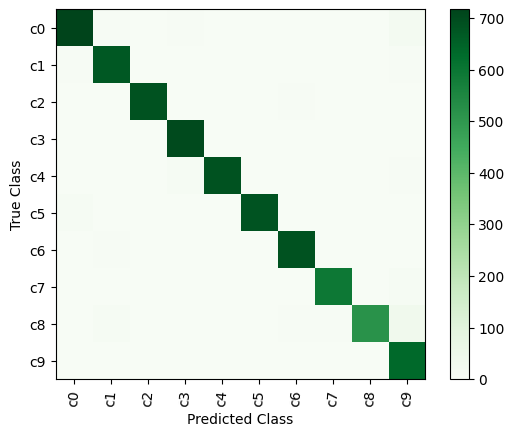

In [51]:
%matplotlib inline

# The folder contains a subfolder for each class of shape.
classes = sorted(os.listdir(training_folder_path))

print("Generating predictions from validation data...")

# Initializing lists to store predictions and true labels.
predictions = []
true_labels = []

# Iterating over each batch.
for i in range(len(validation_generator)):
    # Getting the image and label arrays for the current batch.
    x_test = validation_generator[i][0]
    y_test = validation_generator[i][1]

    # Using the model to predict the class.
    class_probabilities = model_2.predict(x_test)

    # Appending current predictions and true labels to our lists.
    predictions.extend(np.argmax(class_probabilities, axis=1))
    true_labels.extend(np.argmax(y_test, axis=1))

# Converting lists to numpy arrays.
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Plotting the confusion matrix.
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Greens)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

**- Evaluation Metrics:**

In [52]:
# Computing Precision.
precision = precision_score(true_labels, predictions, average='weighted')
print("Precision: ", precision)

# Computing Recall.
recall = recall_score(true_labels, predictions, average='weighted')
print("Recall: ", recall)

# Computing Accuracy.
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy: ", accuracy)

Precision:  0.979190510342216
Recall:  0.9782802737280571
Accuracy:  0.9782802737280571


**Insights:**

1. **Strong Diagonal in Confusion Matrix:** The strong diagonal in the confusion matrix indicates that a majority of your predictions are accurate. The diagonal of a confusion matrix represents true positive predictions where the predicted class is equal to the actual class. A strong diagonal means your model is correctly predicting the classes for a lot of instances.

2. **High Precision:** A precision score of 0.9792 means that when your model predicts a certain class, it is correct about 97.92% of the time. In other words, the model's false positive rate is very low, indicating that the model is precise with its predictions.

3. **High Recall:** A recall score of 0.9783 means that your model identifies 97.83% of all true instances of each class. This indicates that your model has a very low false negative rate, and it's highly sensitive to detecting instances of each class.

4. **High Accuracy:** An accuracy score of 0.9783 indicates that 97.83% of all predictions made by your model are correct. This suggests that the model generalizes well to unseen data, and although this score is worst than model 1, it is still a very promising one for testing.

Validating these results using a completely unseen and unlabeled test set (to ensure that the model generalizes well) will be the next step.

### **• Save Evaluate Model 2 - Custom CNN (Batch 64 - Adam - α = 0.005):**

Save Model 2 with the trained weights, so it can be later reloaded and used to predict classes from new images. 

In [53]:
# Naming the model.
modelFileName = 'distractions_model2_classifier.h5'

# Saving the model in keras model (.h5 file type) to use it with the test data.
model_2.save(modelFileName)
print("Model saved.")

del model_2

Model saved.


### **PART VI: Prediction Stage**

### **• Predict New Data Image Classes with Model 2 - Custom CNN (Batch 64 - Adam - α = 0.005):**

Use Model 2 to predict (infer) the class labels for a new set of images. 

**- Create a function to resize new images to match the dimensions on which the model was trained:**

In [54]:
# Building a function to resize new images.
def resize_image(src_img, size=(128,128), bg_color="white"):
    from PIL import Image

    # Rescaling the image so the longest edge in the right size.
    src_img.thumbnail(size, Image.ANTIALIAS)

    # Creating a new image of the right shape.
    new_image = Image.new("RGB", size, bg_color)

    # Pasting the rescaled image onto the new background.
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))

    # Return the resized image.
    return new_image

**- Create a function to predict the class of a new image:**

In [55]:
# Building a function to predict the class of a new image.
def predict_image(classifier, image_array):
    import numpy as np

    # Formating the input to match the training data.
    # Loading the values as floating point numbers through data generator.
    # Normalizing the pixels.
    img_features = image_array.astype('float32')
    img_features /= 255

    # Predicting the class of each input image.
    predictions = classifier.predict(img_features)

    predicted_classes = []
    for prediction in predictions:
        
        # The prediction for each image is the class with the highest probability. (e.g. [0.8, 0.1, 0.2]).
        # Getting the index of the highest probability.
        class_idx = np.argmax(prediction)

        # Appending the corresponding class name to the results.
        predicted_classes.append(class_labels[int(class_idx)])
    
    # Returning the predictions.
    return predicted_classes

**- Predict image classes - Calling the saved Model:**

In [56]:
# Loading the Model 2.
model_2 = load_model('distractions_model2_classifier.h5')

1/1 [==============================] - 0s 17ms/step


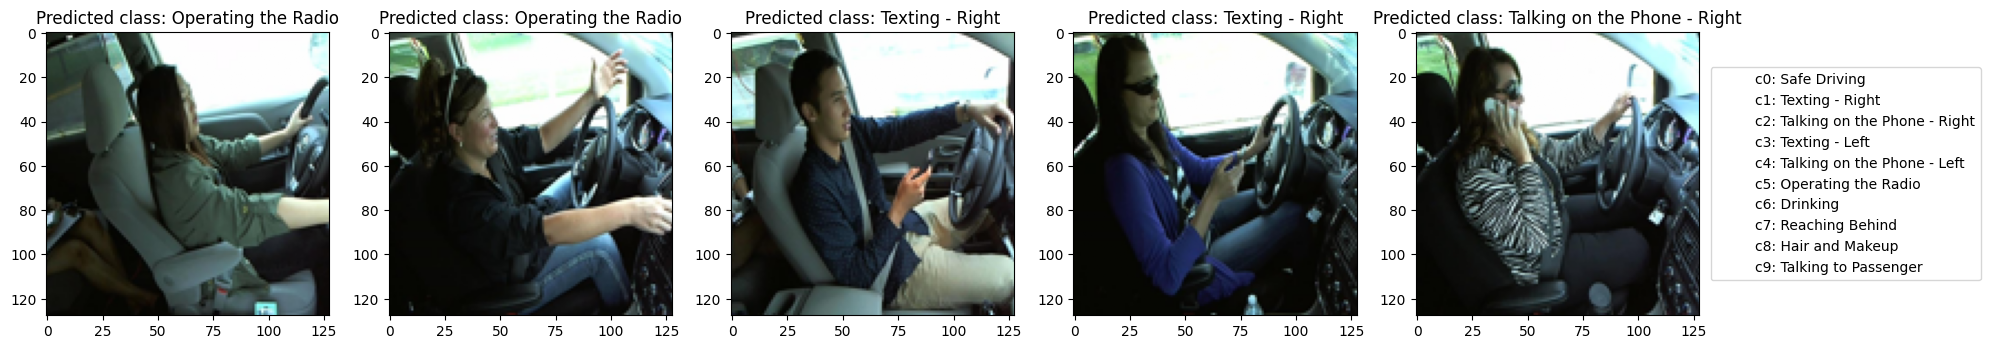

In [57]:
# Creating a function to display sample predictions.
def display_sample_predictions(model, test_folder_path, activity_classes, image_size=(128, 128)):
    import random
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    # Getting a list of all files in the testing folder.
    test_images = os.listdir(test_folder_path)

    # Selecting 5 random images.
    selected_images = random.sample(test_images, 5)

    plt.figure(figsize=(20,10))

    # For each selected image:
    for i, image_name in enumerate(selected_images):
        # Opening the image file.
        img_path = os.path.join(test_folder_path, image_name)
        img = Image.open(img_path)

        # Resizing the image and convert to array.
        img_resized = img.resize(image_size)
        img_array = np.array(img_resized)[np.newaxis, :]

        # Normalizing array.
        img_array = img_array.astype('float32') / 255.0

        # Predicting the image class.
        pred = model.predict(img_array)
        class_idx = np.argmax(pred)

        # Adding 'c' to the class index.
        class_name = activity_classes[f'c{class_idx}']

        # Plotting the image with its predicted class.
        plt.subplot(1, 5, i + 1)
        plt.imshow(img_array[0])
        plt.title(f'Predicted class: {class_name}')
        plt.grid(False)
    
    # Addding a legend with class labels.
    import matplotlib.patches as mpatches
    legend_patches = [mpatches.Patch(color='none', label=f'{k}: {v}') for k, v in activity_classes.items()]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

    plt.tight_layout()
    plt.show()

# Calling the function with the model and testing folder path.
display_sample_predictions(model_2, testing_folder_path, activity_classes)

### **PART VII: Final Conclusion**

In summary, the developed model has displayed stellar performance with **high precision, recall, and accuracy metrics**. Specifically, **precision is marked at 0.9792**, **recall at 0.9783**, and **accuracy also at 0.9783**. This model is additionally **robust, boasting strong validation scores and an effective capability to accurately identify target objects within the images.**

During the **testing phase**,**the model flawlessly identified all 5 images**, thus showcasing a promising potential for superior evaluation on larger datasets, surpassing the previous model. Importantly, the **Adam optimizer continues to exhibit its commendable learning capabilities.** By **raising the learning rate to 0.005**, **the training process accelerated beyond the pace that the previous alpha level could offer, all without meaningfully compromising the model's predictive precision.**

Regarding avenues for improvement, it can be hypothesized that **combining the current problem statement with transfer learning models could prove beneficial.** By leveraging more complex models, ones that have been tested on extensive datasets, the performance might see a **marginal improvement or at least continue to maintain the already high standard.**

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------